In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
print("Libraries loaded!")

Libraries loaded!


In [3]:
df = pd.read_csv("../../data_files/dimuon_data.csv")
len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16986 entries, 0 to 16985
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Run     16986 non-null  int64  
 1   Event   16985 non-null  float64
 2   type1   16985 non-null  object 
 3   E1      16985 non-null  float64
 4   px1     16985 non-null  float64
 5   py1     16985 non-null  float64
 6   pz1     16985 non-null  float64
 7   pt1     16985 non-null  float64
 8   eta1    16985 non-null  float64
 9   phi1    16985 non-null  float64
 10  Q1      16985 non-null  float64
 11  type2   16985 non-null  object 
 12  E2      16985 non-null  float64
 13  px2     16985 non-null  float64
 14  py2     16985 non-null  float64
 15  pz2     16985 non-null  float64
 16  pt2     16985 non-null  float64
 17  eta2    16985 non-null  float64
 18  phi2    16985 non-null  float64
 19  Q2      16985 non-null  float64
 20  M       16985 non-null  float64
dtypes: float64(18), int64(1), object(2)

In [4]:
# statistics of the mass (M)
df['M'].describe()

count    16985.000000
mean        18.420754
std         20.335778
min          0.300700
25%          9.458000
50%         13.092900
75%         19.592100
max        299.202000
Name: M, dtype: float64

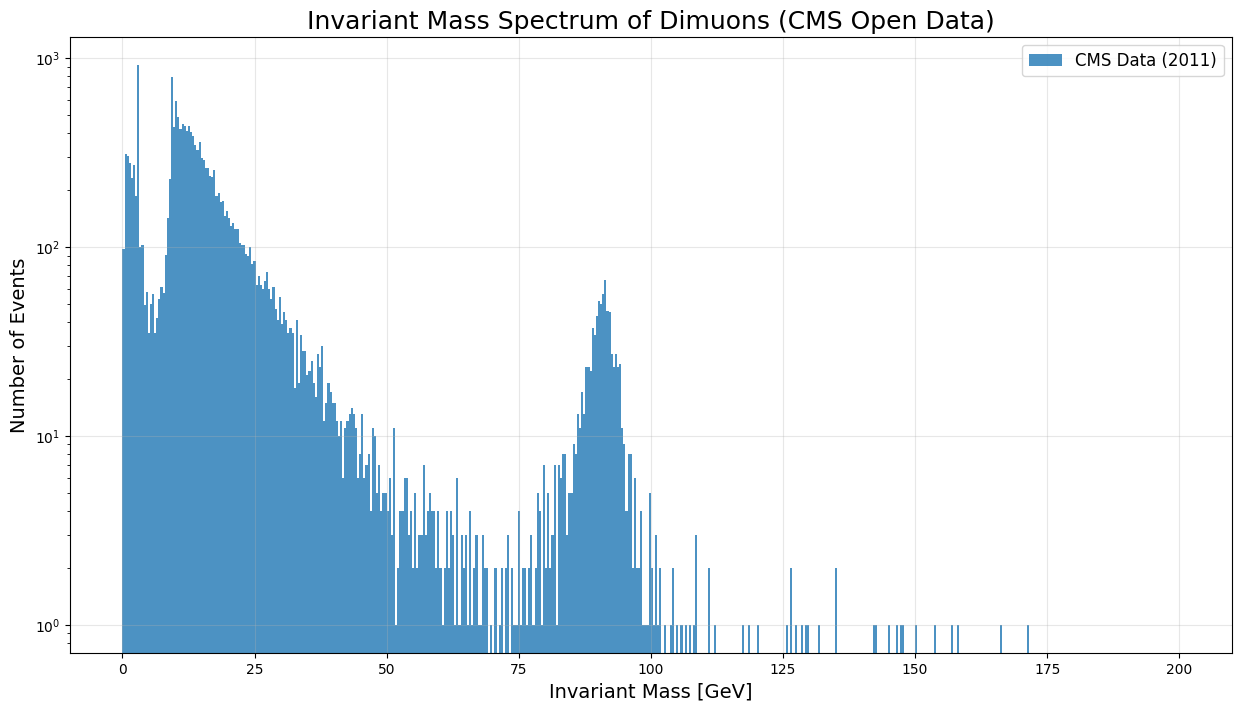

In [5]:
plt.figure(figsize=(15,8))

plt.hist(df['M'], bins=500, range=(0,200), color='#1f77b4', alpha=0.8, label='CMS Data (2011)')

# plt.axvline(91.2, color='red', linestyle='--', linewidth=2, label='Z Boson (91.2 GeV)')
# plt.axvline(3.1, color='orange', linestyle='--', linewidth=2, label='J/Psi (3.1 GeV)')
# plt.axvline(9.4, color='green', linestyle='--', linewidth=2, label='Upsilon (9.4 GeV)')

plt.title("Invariant Mass Spectrum of Dimuons (CMS Open Data)", fontsize=18)
plt.xlabel("Invariant Mass [GeV]", fontsize=14)
plt.ylabel("Number of Events", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)

plt.yscale('log')

plt.show()

75% percentile means 75% of the data is less than that value


In [10]:
df['M'].describe()

count    16985.000000
mean        18.420754
std         20.335778
min          0.300700
25%          9.458000
50%         13.092900
75%         19.592100
max        299.202000
Name: M, dtype: float64

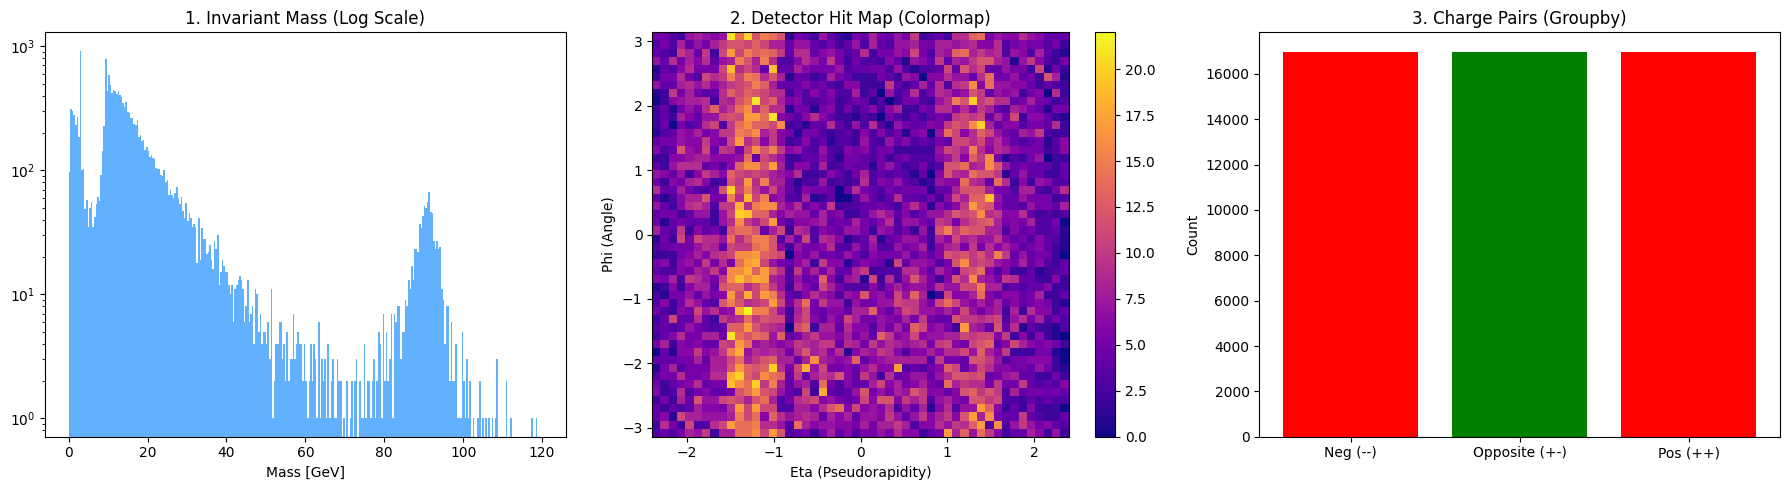

In [49]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# plot 1 mass spectrum
axes[0].hist(df['M'], bins = 300, range=(0,120), color='dodgerblue', alpha=0.7)
axes[0].set_yscale('log')
axes[0].set_title("1. Invariant Mass (Log Scale)")
axes[0].set_xlabel("Mass [GeV]")

# plot 2: 2D Heatmap (Eta vs Phi)
# creating a temporary clean data frame just for this plot
clean_df = df.dropna(subset=['eta1','phi1'])

counts, xedges, yedges, im = axes[1].hist2d(clean_df['eta1'], clean_df['phi1'], bins=50, cmap='plasma')
axes[1].set_title("2. Detector Hit Map (Colormap)")
axes[1].set_xlabel("Eta (Pseudorapidity)")
axes[1].set_ylabel("Phi (Angle)")
plt.colorbar(im, ax=axes[1])

# groupBy charge

charge_groups = df.groupby(df['Q1'] + df['Q2']).size()
colors = ['red', 'green', 'red'] # Green for good (+-), Red for bad (++/--)
axes[2].bar(['Neg (--)', 'Opposite (+-)', 'Pos (++)'], charge_groups, color=colors)
axes[2].set_title("3. Charge Pairs (Groupby)")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.show()

Always `dropna()` or check `isnull().sum()` before feeding real experimental data into a plot.

In [37]:
# Debugging the Charge Groups
# 1. Calculate the sum of charges again
charge_sum = df['Q1'] + df['Q2']
# print(charge_sum.describe())

# 2. Count exactly how many of each exist
counts = charge_sum.value_counts().sort_index()

print("--- 🕵️ DATA INSPECTION ---")
print("Charge Sum | Meaning            | Count")
print("-----------|--------------------|------")
try:
    print(f"   -2      | Negative Pair (--) | {counts.get(-2, 0)}")
    print(f"    0      | Opposite Pair (+-) | {counts.get(0, 0)}")
    print(f"   +2      | Positive Pair (++) | {counts.get(2, 0)}")
except Exception as e:
    print(f"Error reading counts: {e}")
    print("Raw Counts:\n", counts)

--- 🕵️ DATA INSPECTION ---
Charge Sum | Meaning            | Count
-----------|--------------------|------
   -2      | Negative Pair (--) | 0
    0      | Opposite Pair (+-) | 16985
   +2      | Positive Pair (++) | 0


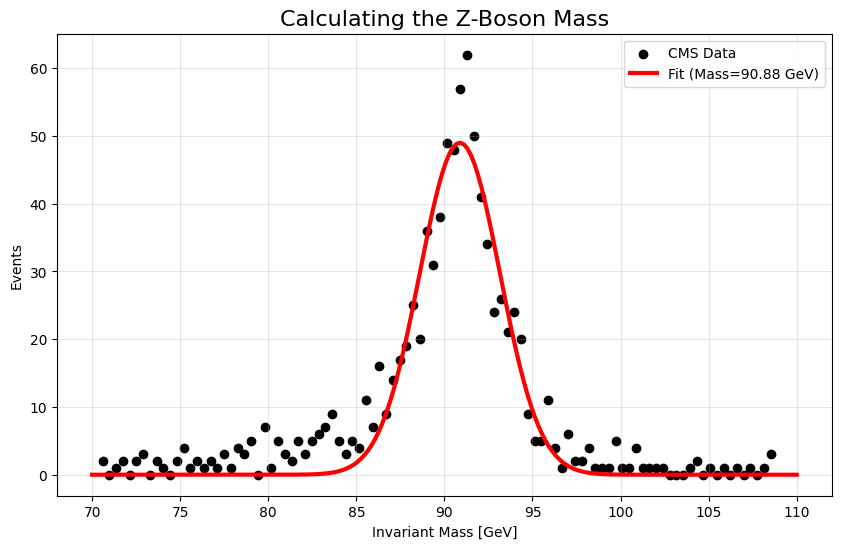

🎯 YOUR MEASUREMENT RESULTS:
   Calculated Mass: 90.8772 GeV
   Accepted Value:  91.1876 GeV
   Difference:      0.3104 GeV


In [39]:
from scipy.optimize import curve_fit

# 1. ZOOM IN: Focus only on the Z-Boson peak (70 - 110 GeV)
z_data = df[(df['M'] > 70) & (df['M'] < 110)]

# 2. PREPARE HISTOGRAM DATA
# We create a histogram with 100 bins to get the "shape" of the peak
counts, bin_edges = np.histogram(z_data['M'], bins=100)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 3. DEFINE THE MODEL: Gaussian (Bell Curve) function
def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-((x - mean)**2) / (2 * stddev**2))

# 4. RUN THE FIT
# Initial guess: Amplitude=500, Mass=91, Width=2
popt, pcov = curve_fit(gaussian, bin_centers, counts, p0=[500, 91, 2])
amp_fit, mass_fit, width_fit = popt

# 5. PLOT THE RESULT
plt.figure(figsize=(10, 6))
# Plot the raw data (black dots)
plt.scatter(bin_centers, counts, color='black', label='CMS Data')
# Plot the fitted curve (red line)
x_smooth = np.linspace(70, 110, 200)
plt.plot(x_smooth, gaussian(x_smooth, *popt), color='red', linewidth=3, label=f'Fit (Mass={mass_fit:.2f} GeV)')

plt.title("Calculating the Z-Boson Mass", fontsize=16)
plt.xlabel("Invariant Mass [GeV]")
plt.ylabel("Events")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"🎯 YOUR MEASUREMENT RESULTS:")
print(f"   Calculated Mass: {mass_fit:.4f} GeV")
print(f"   Accepted Value:  91.1876 GeV")
print(f"   Difference:      {abs(mass_fit - 91.1876):.4f} GeV")

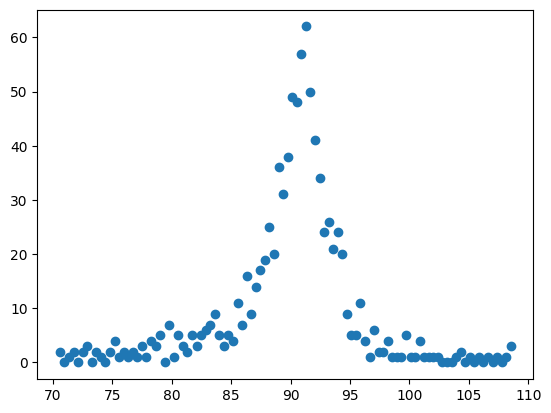

In [47]:
z_data = df[(df['M'] > 70) & (df['M'] < 110)]
counts, bean_edges = np.histogram(z_data['M'], bins=100)
bean_center = (bean_edges[:-1] + bean_edges[1:]) /2
plt.scatter(bean_center, counts)